# Initialization

In [0]:
!pip install -U googlemaps

In [0]:
!pip install gmplot

In [0]:
from  googlemaps import Client
from google.colab import files
from random import shuffle, randint, random
from math import exp
from gmplot import *
from datetime import datetime, timedelta
from timeit import default_timer as timer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
gmaps = Client(key='your API key')

In [0]:
uploaded = files.upload()

Saving 25_London.csv to 25_London.csv


# Coordinates

In [0]:
df = pd.read_csv("25_London.csv")
df["LAT"] = None
df["LON"] = None

In [0]:
for i in range(len(df)):
  geocode_result = gmaps.geocode(df.iat[i,0])
  try:
      df.iat[i, df.columns.get_loc("LAT")] = geocode_result[0]["geometry"]["location"]["lat"]
      df.iat[i, df.columns.get_loc("LON")] = geocode_result[0]["geometry"]["location"]["lng"]
      #df.iat[i, df.columns.get_loc("COORDINATES")] = df.iat[i, df.columns.get_loc("LON")] df.iat[i, df.columns.get_loc("LAT")]

  except:
      lat = None
      lon = None

Coordinates = np.zeros((len(df), 3))
for i in range(len(df)):
  Coordinates[i] = i+1, df.LON[i], df.LAT[i] 

print(df)

                                          ADDRESS      TYPE      LAT        LON
0                            11 Porlock St London     DEPOT  51.5012 -0.0885404
1                            71 Central St London  DELIVERY  51.5266 -0.0967936
2                          17 Edway Rd bow London  DELIVERY  51.5303 -0.0352679
3                   9 Lockmean Rd Lewisham London  DELIVERY  51.4638 -0.0084496
4             93 Albert Embankment Lambeth London  DELIVERY  51.4894  -0.123143
5                  138 Druid St Bermondsey London  DELIVERY  51.4983  -0.072756
6               88 Denmark Hill Camberwell London  DELIVERY  51.4717 -0.0932589
7          10 Abbey Orchard St Westminster London  DELIVERY  51.4976   -0.13272
8                  138 Druid St Bermondsey London  DELIVERY  51.4983  -0.072756
9                        33 Cumberland St Pimlico  DELIVERY  51.4889  -0.144756
10                        33 Clabon Mews Chelsea   DELIVERY   51.495  -0.162017
11                         88 Hackford R

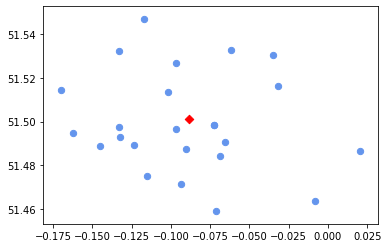

In [0]:
# Plotting
for i in range(len(df)):
  if df.TYPE[i] == 'DEPOT':
    plt.scatter(df.LON[i], df.LAT[i], c='r', marker='D')
  elif df.TYPE[i] == 'DELIVERY': 
    plt.scatter(df.LON[i], df.LAT[i], c='cornflowerblue', marker='o', s=40)

# Distance Matrix

In [0]:
#Creating Distance Matrix with traffic information (seconds)
Distance_Matrix = np.zeros((len(df),len(df)))
now = datetime.now()

for i in range(len(df)):
  for j in range(len(df)):
    dist = gmaps.distance_matrix( df.iat[i, df.columns.get_loc("ADDRESS")], df.iat[j, df.columns.get_loc("ADDRESS")],mode="driving", departure_time = now, avoid="tolls")
    Distance_Matrix[i,j] = dist["rows"][0]["elements"][0]["duration_in_traffic"]["value"]

In [0]:
#Creating Distance Matrix with Duration (seconds)
Distance_Matrix = np.zeros((len(df),len(df)))

for i in range(len(df)):
  for j in range(len(df)):
    dist = gmaps.distance_matrix( df.iat[i, df.columns.get_loc("ADDRESS")], df.iat[j, df.columns.get_loc("ADDRESS")])
    Distance_Matrix[i,j] = dist["rows"][0]["elements"][0]["duration"]["value"]

In [0]:
#Creating Distance Matrix with Distance (meters)
Distance_Matrix = np.zeros((len(df),len(df)))

for i in range(len(df)):
  for j in range(len(df)):
    dist = gmaps.distance_matrix( df.iat[i, df.columns.get_loc("ADDRESS")], df.iat[j, df.columns.get_loc("ADDRESS")])
    Distance_Matrix[i,j] = dist["rows"][0]["elements"][0]["distance"]["value"]

# Functions

In [0]:
def First_Tour(leng):
  FirstTour = list(range(2, leng+1))
  shuffle(FirstTour)
  FirstTour = [1] + FirstTour + [1]
  return FirstTour

def iter_num(temp, rate, mitemp):
  number = 0 
  while True:
    temp *= rate
    if temp <= mitemp:break
    number+=1
  return number

def Plotting(tour, coords):
  n=len(tour)
  longitude=[]
  latitude=[]

  for i in range(n):
    longitude.append(coords[tour[i]-1, 1])
    latitude.append(coords[tour[i]-1, 2])

  plt.figure()    
  plt.plot([longitude[i] for i in range(n)], [latitude[i] for i in range(n)],'-.', color='cornflowerblue')
  for i in range(len(df)):
    if df.TYPE[i] == 'DEPOT':
      plt.scatter(df.LON[i], df.LAT[i], c='r', marker='D')
    elif df.TYPE[i] == 'DELIVERY': 
      plt.scatter(df.LON[i], df.LAT[i], c='cornflowerblue', marker='o', s=40)

def FindCurrentCost(CurTour):
  temporaryDis=0
  for i in range(len(CurTour)-1):    
      temporaryDis += Distance_Matrix[CurTour[i]-1,CurTour[i+1]-1]
  return temporaryDis 

def decode(point_str):
    # sone coordinate offset is represented by 4 to 5 binary chunks
    coord_chunks = [[]]
    for char in point_str:
        
        # convert each character to decimal from ascii
        value = ord(char) - 63
        
        # values that have a chunk following have an extra 1 on the left
        split_after = not (value & 0x20)         
        value &= 0x1F
        
        coord_chunks[-1].append(value)
        
        if split_after:
                coord_chunks.append([])
        
    del coord_chunks[-1]
    
    coords = []
    
    for coord_chunk in coord_chunks:
        coord = 0
        
        for i, chunk in enumerate(coord_chunk):                    
            coord |= chunk << (i * 5) 
        
        #there is a 1 on the right if the coord is negative
        if coord & 0x1:
            coord = ~coord #invert
        coord >>= 1
        coord /= 100000.0
                    
        coords.append(coord)
    
    # convert the 1 dimensional list to a 2 dimensional list and offsets to 
    # actual values
    points = []
    prev_x = 0
    prev_y = 0
    for i in range(0, len(coords) - 1, 2):
        if coords[i] == 0 and coords[i + 1] == 0:
            continue
        
        prev_x += coords[i + 1]
        prev_y += coords[i]
        # a round to 6 digits ensures that the floats are the same as when 
        # they were encoded
        points.append((round(prev_x, 6), round(prev_y, 6)))
    
    return points    

# New Tour

In [0]:
def NewTourRev(seq):
    tmp=seq[0]
    del seq[0]
    del seq[-1]      

    i = randint(0,  len(seq)- 2)
    j = randint(i+2, len(seq))

    seq[i:j] = reversed(seq[i:j])
    
    seq.insert(0,tmp)
    seq.append(tmp)
    
    return seq

# Simulated Annealing

3.4220 sec
67209.0
222500


<Figure size 432x288 with 0 Axes>

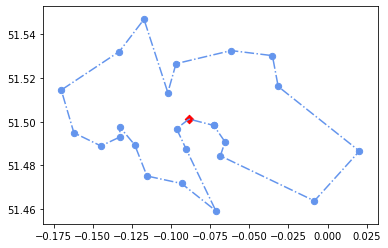

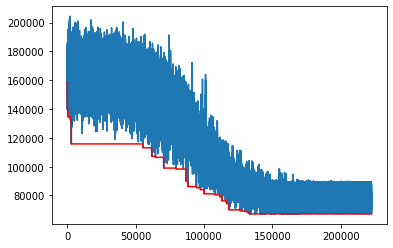

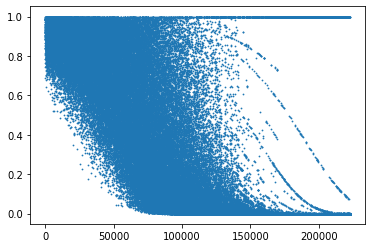

In [0]:
start = timer()

FirstTour = First_Tour(len(df))
Shortest_Tour_Cost=9999999999
Temperature = 40000
alpha = 0.997
mintemp = 50
innerloop = len(df)*4

Shortest_Tour_Graph=[]
Cost_Graph=[]
Xo = FirstTour[:]
Fxo=FindCurrentCost(FirstTour)
Temperature_Graph=[]
accepted_metropolis = []
Df_graph=[]
y=[]
ran_graph=[]
position = 0

while True:
    for i in range(innerloop):
        Xnew=NewTourRev(Xo[:])
        Fxnew=FindCurrentCost(Xnew)
        accepted_metropolis.append(None) 

        Df=Fxo-Fxnew
        Df_graph.append(Df)
        Cost_Graph.append(Fxnew)

        if Df > 0:
            Xo=Xnew[:]
            Fxo = Fxnew    
        else:
            p = exp(Df/Temperature)
            ran=random()
            ran_graph.append(ran)
            if ran < p:
                Xo=Xnew[:]
                Fxo = Fxnew
            accepted_metropolis[-1]=p  
 
        if Fxo < Shortest_Tour_Cost:
            Shortest_Tour_Cost=Fxo
            Shortest_Tour= Xo[:]

        y.append(position)
        position +=1

        Shortest_Tour_Graph.append(Shortest_Tour_Cost)    
        #Cost_Graph.append(Fxo)
        Temperature_Graph.append(Temperature)  
    Temperature*= alpha
    if Temperature <= mintemp:break  

end = timer() 

    
plt.figure()
plt.plot(Cost_Graph)
plt.plot(Shortest_Tour_Graph,'r')

plt.figure()
plt.scatter(y, accepted_metropolis,s=0.6)

print("Shortest Tour:",Shortest_Tour)
print("Shortest Tour cost:","{0:.3f}".format(round(Shortest_Tour_Cost,3)))
print("Calculation Time:","{0:.4f}".format(round((end - start),4)), "sec")
Plotting(Shortest_Tour, Coordinates)
plt.figure()
plt.plot(Shortest_Tour_Graph,'r')

In [0]:
# printing the route plan by order
for i in ShortestTour:
  print(df.ADDRESS[i-1])

11 Porlock St London
 29 Bath Terrace London
122 Portland St Walworth London
42 Crystal Palace Rd London
88 Denmark Hill Camberwell London
88 Hackford Rd London 
93 Albert Embankment Lambeth London
10 Abbey Orchard St Westminster London
70 Vincent St Westminster London 
33 Cumberland St Pimlico
 33 Clabon Mews Chelsea 
38 Gloucester Square Hyde Park Estate London 
2 Aldenham St Kings Cross London
14 MacKenzie Rd London
58 Carter Ln London
71 Central St London
16 Pritchard's Rd London
17 Edway Rd bow London
23 Clemence St London
172 Woolwich Rd Greenwich Peninsula London
9 Lockmean Rd Lewisham London
518 Old Kent Rd London 
198 St James's Rd Bermondsey London
138 Druid St Bermondsey London
138 Druid St Bermondsey London
11 Porlock St London


# Plotting on Google Maps

In [0]:
# Athens Coordinates
#gmap = gmplot.GoogleMapPlotter(37.983616, 23.728616, 11)

# London Coordinates
gmap = gmplot.GoogleMapPlotter(51.509865, -0.118092, 12)

# or else add your prefered coordinates of the centered point 

gmap.apikey = 'your API key'

# API Request
now = datetime.now()

latitudes = [df.LAT[0]]
longitudes = [df.LON[0]]

for i in range(len(ShortestTour)-1):
  directions_result = gmaps.directions(df.ADDRESS[ShortestTour[i]-1], df.ADDRESS[ShortestTour[i+1]-1], mode="driving", departure_time = now, avoid="tolls")
  
  for j in range(len(directions_result[0]["legs"][0]["steps"])-1):
    coors = decode(directions_result[0]["legs"][0]["steps"][j]["polyline"]["points"])
    for n in range(len(coors)):
      latitudes.append(coors[n][1])
      longitudes.append(coors[n][0])


latitudes.append(df.LAT[0])
longitudes.append(df.LON[0])    
gmap.plot(latitudes, longitudes, 'cornflowerblue', edge_width=10)

# plot different coloros about the type
# purple for DEPOT & green for DELIVERY

for i in range(len(df)):
  if df.TYPE[i] == 'DEPOT':
    gmap.scatter(tuple([df.LAT[i]]), tuple([df.LON[i]]),'#ff00ff',size=40, marker=False)
  elif df.TYPE[i] == 'DELIVERY':
    gmap.scatter(tuple([df.LAT[i]]), tuple([df.LON[i]]),'#00ff00',size=40, marker=False)

gmap.draw("London_map.html")

In [0]:
files.download("London_map.html") 